 # TP 6: Apprentissage profond(Deep learning)
 ## TP 6.4  : Optimisation 
 
- Régularisation :  Dropout
- Normalisation 
    - Inputs
    - les autres couches (batch Normalisation: avant ou après l'activation)
- Optimiseurs: 
    - RMSProp, Adam, SGD, 
- Hyperparameter tuning : 
    - learning_rate
    - \#couches
    - \#neurones par couche
    - taille du mini batch 
- ...
# Exercice
Trouver le meilleur modèle pour les données  de "smoking"
Le programme doit tester les différentes configurations (et hyperparamètres).

Visiter le site keras ou tensorflow pour vérifier la maniène d'utiliser ces différents paramètres

PS : comparer aussi avec les modèes classiques : (KNN, Randomforest, ...) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings


In [2]:
warnings.filterwarnings("ignore")
tf.random.set_seed(42)

In [3]:
# Lecture du dataset n permet de limiter le nombre de lignes à lire
# Pour faciliter les tests

def load_data(n):
    data = pd.read_csv('../data/train.new.csv')
    return data[0:n]

def select_variables(data):
    data.dropna(axis=0, inplace=True)
    y = data['smoking'] # récupérer la colonne survived et la mettre dans y
    X = data.drop('country', axis=1)
    X = X.drop('id', axis=1)
    X = X.replace(["M", "F"], [0, 1])
    X = X.drop('smoking', axis=1)
    return X,y

In [4]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
normalizer = RobustScaler()


In [5]:
data=load_data(-1)
# sélectionner les variables
X,y = select_variables(data)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [6]:
X_test, y_test

(array([[-1.33333333,  1.        ,  1.5       , ..., -0.125     ,
         -0.42307692,  0.        ],
        [-1.33333333,  0.        ,  1.        , ..., -0.625     ,
          0.38461538,  1.        ],
        [-0.33333333,  1.        ,  0.5       , ...,  1.6875    ,
          0.92307692,  0.        ],
        ...,
        [ 2.        ,  1.        , -0.5       , ..., -0.5625    ,
          0.19230769,  0.        ],
        [ 1.33333333,  0.        , -1.5       , ...,  0.625     ,
         -0.19230769,  0.        ],
        [-0.33333333,  0.        ,  1.        , ...,  0.8125    ,
          0.61538462,  1.        ]]),
 79635     1
 147007    1
 46083     1
 103949    1
 45300     1
          ..
 46310     0
 34606     1
 66883     0
 142476    0
 12769     1
 Name: smoking, Length: 27325, dtype: int64)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import Hyperband

def build_model(hp):
    model = keras.Sequential()
    
    # Add layers based on the best hyperparameters
    for _ in range(hp.Int('nb_layers', min_value=2, max_value=5)):
        if model.layers != []:
            if hp.Choice('add_dropout_and_batch', values=[True, False]):
                model.add(layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
                model.add(layers.BatchNormalization())
        model.add(layers.Dense(units=hp.Int('nb_units', min_value=32, max_value=528, step=64),
                               activation='relu'))
        model.add(layers.C)

    model.add(layers.Dense(1, activation='sigmoid'))
    # Decay learning rate
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),
        decay_steps=10000,
        decay_rate=0.9)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [14]:
def build_hierarchical_model(hp):
    model = keras.Sequential()
    
    # Add layers based on the best hyperparameters
    tot_units = hp.Int('nb_units', min_value=32, max_value=528, step=64)
    #each layer have 2 times less units than the previous one
    while tot_units >= 32:
        if (model.layers != []):
            model.add(layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
            model.add(layers.BatchNormalization())
        model.add(layers.Dense(units=tot_units, activation='relu'))
        tot_units = tot_units // 2
    model.add(layers.Dense(1, activation='sigmoid'))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
def tune_model(X_train, y_train, X_test, y_test):
    tuner = Hyperband(build_hierarchical_model,
                      objective='val_accuracy',
                      max_epochs=30,
                      factor=3,
                      hyperband_iterations=8,
                      directory='my_dir',
                      project_name='intro_to_kt')
    
    tuner.search(X_train, y_train,
                 epochs=50,
                    validation_data=(X_test, y_test))
    
    best_hps = tuner.get_best_hyperparameters()[0]
    
    return best_hps

In [19]:
best_hps = tune_model(X_train, y_train, X_test, y_test)

Trial 153 Complete [00h 00m 28s]
val_accuracy: 0.7692589163780212

Best val_accuracy So Far: 0.7763952612876892
Total elapsed time: 01h 06m 14s


In [24]:
#get the top 10 models
best_hps.get('learning_rate'), best_hps.get('nb_units'), best_hps.get('dropout')

(0.001, 96, 0.2)

# Meilleur modèle pour l'instant :
- 3 couches cachées
- Une de 96 neurones
- Une de 48 neurones
- Une de 24 neurones
- Dropout de 0.2
- Batch Normalisation avant l'activation
- Optimiseur : Adam
- Learning rate : 0.001 (test en cours avec un learning rate dynamique)

# Résultats :
- 0.777 de précision sur le test set

In [47]:
model = keras.Sequential()
model.add(layers.Input(shape=(X_train.shape[1],)))
model.add(layers.Dense(units=526, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dropout(best_hps.get('dropout')))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
lr = best_hps.get('learning_rate')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=16)

Epoch 1/200
6832/6832 [==============================] - 9s 1ms/step - loss: 0.5075 - accuracy: 0.7406 - val_loss: 0.4658 - val_accuracy: 0.7693
Epoch 2/200
6832/6832 [==============================] - 8s 1ms/step - loss: 0.4895 - accuracy: 0.7530 - val_loss: 0.4636 - val_accuracy: 0.7658
Epoch 3/200
6832/6832 [==============================] - 8s 1ms/step - loss: 0.4882 - accuracy: 0.7538 - val_loss: 0.4594 - val_accuracy: 0.7711
Epoch 4/200
6832/6832 [==============================] - 8s 1ms/step - loss: 0.4849 - accuracy: 0.7577 - val_loss: 0.4619 - val_accuracy: 0.7683
Epoch 5/200
6832/6832 [==============================] - 8s 1ms/step - loss: 0.4833 - accuracy: 0.7579 - val_loss: 0.4613 - val_accuracy: 0.7704
Epoch 6/200
6832/6832 [==============================] - 8s 1ms/step - loss: 0.4820 - accuracy: 0.7581 - val_loss: 0.4591 - val_accuracy: 0.7705
Epoch 7/200
6832/6832 [==============================] - 8s 1ms/step - loss: 0.4815 - accuracy: 0.7595 - val_loss: 0.4599 - val_ac

Text(0.5, 0, 'Epoch')

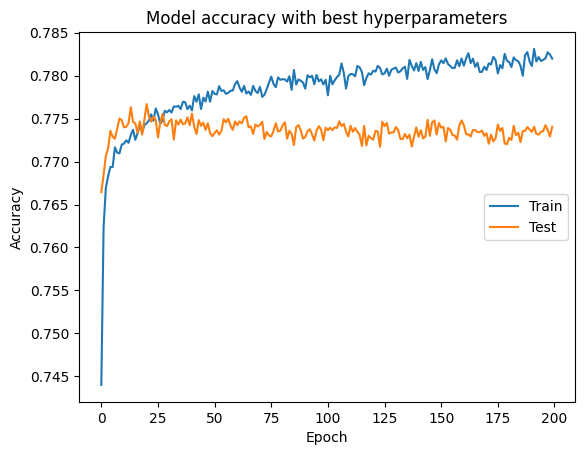

In [43]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='right')
plt.title('Model accuracy with best hyperparameters')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
gpt_model = keras.Sequential()
model = keras.Sequential([
    keras.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.Dense(64, activation='relu'),
    keras.Dense(32, activation='relu'),
    keras.Dense(1, activation='sigmoid')
])



### Définition du modèle 
avec prise d'un nombre de couches et nombre de neurones variables 

### 4. Entrainement du modèle (Model training)

### 5. Evaluation des performances du modèle 


In [ ]:
def visualiser_confusion(model, X_test, y_test):
    y_pred = model.predict(X_test)
    # Get class labels
    y_classes = np.argmax(y_pred, axis=-1)

    cm = confusion_matrix(y_test, y_classes)
    #disp= ConfusionMatrixDisplay(confusion_matrix=cm)

    sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
    plt.show()


### Main program

In [ ]:
# Préparation ds données
# le -1 du load_data(-1) veut dire on prend toutes les lignes 
data=load_data(-1)
# sélectionner les variables
X,y = select_variables(data)
X_train, X_test, y_train, y_test = split_data(X,y)
X_train, X_test = normaliser(X_train, X_test)


#### Afficher les paramètres du meilleur modèle

In [ ]:
best_param_model

In [ ]:
best_param_model["#layers"]

#### Play with the best model

In [ ]:
## sur les données de Text (X_test, y_test)

score = evaluer(model, X_test, y_test)
print('Test loss     :', score[0])
print('Test accuracy :', score[1])

In [ ]:
print('Test loss     :', score[0])
print('Test accuracy :', score[1])